In [198]:
%matplotlib inline
import healpy as hp
from lusee.mono_sky_models import T_DarkAges
import matplotlib.pyplot as plt
import numpy as np 

The short ($L << \lambda/2$) dipole power in the farfield for an antenna of length L goes as
$$P(\theta, \lambda) \propto \left(\frac{L}{\lambda}\right)^2 \sin^2{\theta} \iff P(\theta, \nu) \propto (L\nu)^2 \sin^2{\theta} $$

In the equation above, $\theta$ is the angle to the current. In spherical coordinates, where $\theta$ is the polar angle, the power is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In the language of [spherical harmonics](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics), the power is completely described by the $\ell=0$ and $\ell=2$ modes:
$$P(\theta, \nu) \propto (L\nu)^2 \left(\frac{3\sqrt{5}}{2}Y_0^0(\theta) + Y_2^0(\theta) \right)$$

In [199]:
def dipole_map(frequency, ant_length=1, nside=16, lmax=2):
    """
    Get dipole power pattern in the far field for a single frequency.
    """    
    mmax = lmax
    size = int(mmax * (2 * lmax + 1 - mmax) / 2 + lmax + 1)
    
    l_eff_sq = (ant_length * frequency) ** 2 
    a00 = l_eff_sq * 3 * np.sqrt(5) / 2
    a20 = l_eff_sq
    
    alm = np.zeros(size, dtype=complex)
    alm[0] = a00
    alm[2] = a20
    
    hp_map = hp.alm2map(alm, nside)
    
    return hp_map

def dipole_maps(frequencies, **kwargs):
    """
    Get the maps for many frequencies
    """
    f0 = frequencies[0]
    ref_map = dipole_map(f0, **kwargs)
    ref_map.shape = (1, -1)
    frequencies = frequencies.reshape(-1, 1)
    maps = (frequencies/f0)**2 * ref_map
    return maps

In [200]:
freq = np.linspace(1, 50, 101)
beams = dipole_maps(freq, ant_length=1, nside=64)

In [201]:
# horizon cutoff
mask = np.ones_like(beams[0])
mask[len(mask)//2:] = 0

beams *= mask

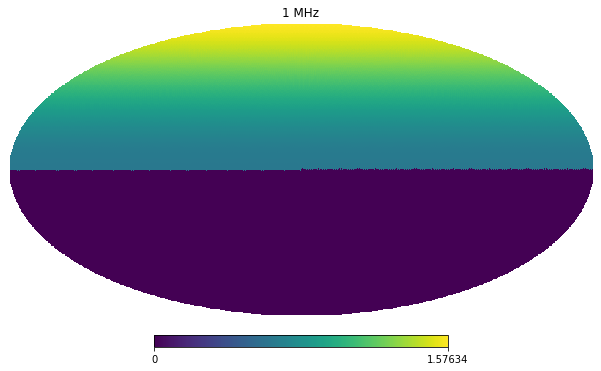

In [202]:
hp.mollview(beams[0], title="1 MHz")

In [203]:
d = beams.T 
d -= d.mean(axis=0)
C = d.T @ d
U, S, V = np.linalg.svd(C)

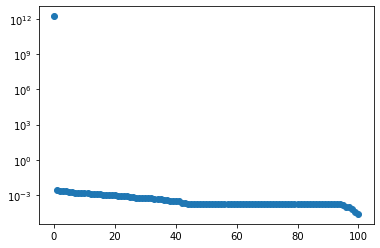

In [204]:
eig_nr = np.arange(len(S))

plt.figure()
plt.scatter(eig_nr, S)
plt.yscale("log")
plt.show()

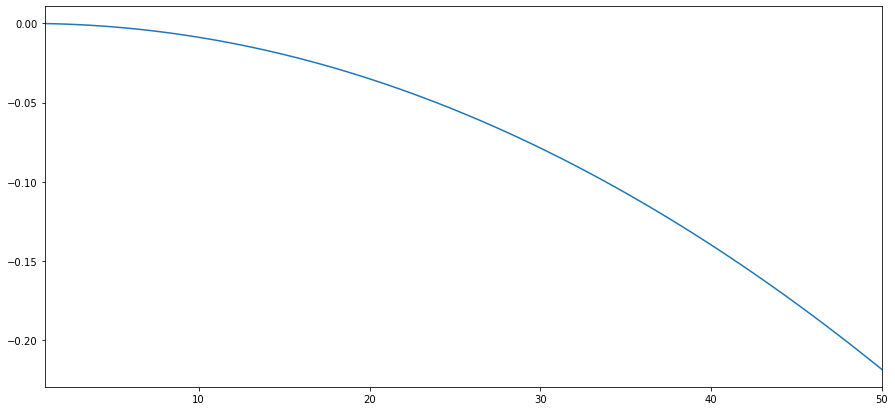

In [205]:
plt.figure(figsize=(15,7))
plt.plot(freq, V[0].T)
plt.xlim(freq.min(), freq.max())
plt.show()

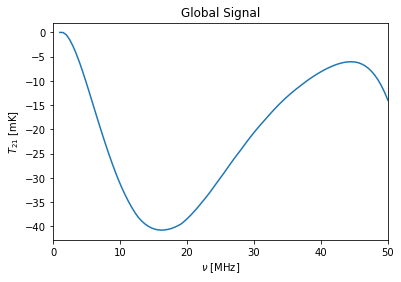

In [206]:
t21 = T_DarkAges(freq) * 1e3
plt.figure()
plt.plot(freq, t21)
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("$T_{21}$ [mK]")
plt.title("Global Signal")
plt.xlim(0, freq.max())
plt.show()

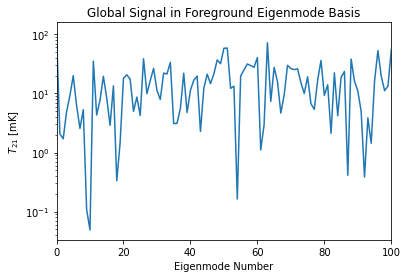

In [207]:
proj_t21 = np.abs(V @ t21)


plt.figure()
plt.plot(eig_nr, proj_t21)
plt.xlabel("Eigenmode Number")
plt.ylabel("$T_{21}$ [mK]")
plt.title("Global Signal in Foreground Eigenmode Basis")
plt.xlim(eig_nr.min(), eig_nr.max())
plt.yscale("log")
plt.show()

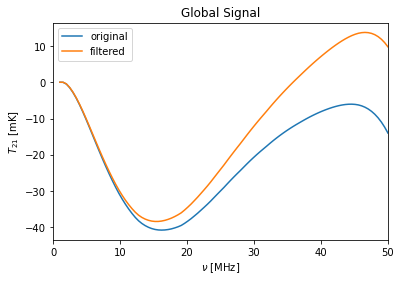

In [208]:
f21 = V @ t21
f21[0] = 0  # remove brightest fg mode
rec_21 = np.linalg.inv(V) @ f21

plt.figure()
plt.plot(freq, t21, label="original")
plt.plot(freq, rec_21, label="filtered")
plt.xlabel("$\\nu$ [MHz]")
plt.ylabel("$T_{21}$ [mK]")
plt.title("Global Signal")
plt.xlim(0, freq.max())
plt.legend()
plt.show()